### Домашнее задание к вебинару 6

Попробуйте обучить нейронную сеть с применением одномерных сверток для предсказания сентимента сообщений с твитера на примере https://www.kaggle.com/datasets/arkhoshghalb/twitter-sentiment-analysis-hatred-speech

Опишите, какой результат вы получили? Что помогло вам улучшить ее точность?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split

# для обработки текста
from string import punctuation
from stop_words import get_stop_words

import nltk
nltk.download("punkt")
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

# для сети
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
train_path = '../input/twitter-sentiment-analysis-hatred-speech/train.csv'
test_path = '../input/twitter-sentiment-analysis-hatred-speech/test.csv'

data_train = pd.read_csv(train_path)
data_test = pd.read_csv(test_path)

In [3]:
data_train.head(3)

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty


In [4]:
data_test.head(3)

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...


In [5]:
data_train.label.value_counts()

0    29720
1     2242
Name: label, dtype: int64

Есть выраженный дисбаланс

In [6]:
data_train.loc[data_train.label == 1, 'tweet'].tail(10)

31912    i couldn't end #2016 without mentioning #trump...
31926    a follow up from the gentlemen who were kicked...
31929    did  keep #colinpowell and #condoleezzarice fr...
31930    @user #feminismiscancer #feminismisterrorism #...
31933    @user judd is a  &amp; #homophobic #freemilo #...
31934    lady banned from kentucky mall. @user  #jcpenn...
31946    @user omfg i'm offended! i'm a  mailbox and i'...
31947    @user @user you don't have the balls to hashta...
31948     makes you ask yourself, who am i? then am i a...
31960    @user #sikh #temple vandalised in in #calgary,...
Name: tweet, dtype: object

In [7]:
data_train.loc[data_train.label == 0, 'tweet'].head(5)

0     @user when a father is dysfunctional and is s...
1    @user @user thanks for #lyft credit i can't us...
2                                  bihday your majesty
3    #model   i love u take with u all the time in ...
4               factsguide: society now    #motivation
Name: tweet, dtype: object

Класс 0 - твит является положительным, класс 1 - твит негативный, расистский. Твиты на английском языке, что важно учесть в будущей обработке.

In [8]:
# Разделим тренировочные данные на тренировочную и валидационную выборки

data_train, data_val = train_test_split(data_train, test_size = 0.3, random_state = 1)

data_train.label.value_counts(), data_val.label.value_counts()

(0    20780
 1     1593
 Name: label, dtype: int64,
 0    8940
 1     649
 Name: label, dtype: int64)

In [9]:
# Попробуем избавиться от дисбаланса классов на тренировочной выборке, дисбаланс слишком выражен
def oversampling_by_target(df, target_name):
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [10]:
data_train = oversampling_by_target(data_train, 'label')

In [11]:
data_train.label.value_counts()

0    20780
1    20709
Name: label, dtype: int64

**Предобработка твитов**

In [12]:
max_words = 2000
max_len = 40
num_classes = 1

# обучение
epochs = 10
batch_size = 512
print_batch_n = 100

In [13]:
# Загрузим стоп - слова
sw1 = get_stop_words('english')
sw2 = stopwords.words('english')

In [14]:
# Соберем все стоп-слова вместе
sw_all = set(sw1+sw2)
len(sw_all)

211

In [15]:
# Загрузим пунктуацию
puncts = set(punctuation)
puncts

{'!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 '{',
 '|',
 '}',
 '~'}

In [16]:
# Лемматизация
# pymorphy не работает с английским языком, поэтому берем WordNetLemmatizer из nltk


lemmatizer = WordNetLemmatizer()

#пример 
lemmatizer.lemmatize('cities'), lemmatizer.lemmatize('children'), lemmatizer.lemmatize('walking')

('city', 'child', 'walking')

In [17]:
def preprocess_text(txt):
    # переводчим в строковый тип
    txt = str(txt)
    
    # убираем пунктауицию
    txt = "".join(c for c in txt if c not in puncts)
    
    # переводим в нижний регистр
    txt = txt.lower()
     
    # лемматизация
    txt = [lemmatizer.lemmatize(word) for word in txt.split() if word not in sw_all]
    return " ".join(txt)

In [18]:
print(f"{data_train['tweet'].iloc[3]} --> {preprocess_text(data_train['tweet'].iloc[3])}")

@user thank you!! the power of #social #media!   @user #aande  --> user thank power social medium user aande


In [19]:
#преобразование текста в данных
from tqdm import tqdm 
tqdm.pandas()

data_train['tweet'] = data_train['tweet'].progress_apply(preprocess_text)
data_val['tweet'] = data_val['tweet'].progress_apply(preprocess_text)
data_test['tweet'] = data_test['tweet'].progress_apply(preprocess_text)

100%|██████████| 17197/17197 [00:01<00:00, 15176.96it/s]


In [20]:
data_train.tweet

5236     user congratulation deepu di need pachay miss ...
26680    user user ball lumpy girl spot lumpy tony say ...
5978     magnettherapy really work altwaystoheal healin...
30068            user thank power social medium user aande
7217                               user user american hate
                               ...                        
18346    little pink pocket dream caught midair jump mi...
14983    hour 25pm gourmethotdogs couvesmallbiz friday ...
38824    hispanic amp feel like stomping listen retweet...
32285    user user safe place black country people like...
38661    goodonedean metoo lol trumpism putinism donald...
Name: tweet, Length: 41489, dtype: object

In [21]:
# делаем единый список слов из всех слов во всех строках

train_corpus = " ".join(data_train["tweet"])
train_corpus = train_corpus.lower()
len(train_corpus)

2621370

In [22]:
# Токенизация
tokens = word_tokenize(train_corpus) #на выходе будет лист токенов
tokens[:5]


['user', 'congratulation', 'deepu', 'di', 'need']

In [23]:
# Сделаем фильтрацию токенов и отберем N самых часто встречающихся

# Отфильтруем те токены, которые не являются словами (буквами) или цифрами
tokens_filtered = [word for word in tokens if word.isalnum()]

In [24]:
# Сделаем словарь {слово: частота появления},
# Вывод будет отсортирован в порядке убывания популярности слова 

dist = FreqDist(tokens_filtered)
dist

FreqDist({'user': 27717, 'amp': 3196, 'love': 2070, 'trump': 1989, 'like': 1979, 'day': 1952, 'u': 1809, 'white': 1645, 'black': 1557, 'people': 1465, ...})

In [25]:
# Отберем первые N наиболее популярных токенов с паддингом = 1, 
# чтобы в будущем использовать 0 в качестве пустого значения

tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]  # -1 - padding
len(tokens_filtered_top), tokens_filtered_top[:10]

(1999,
 ['user',
  'amp',
  'love',
  'trump',
  'like',
  'day',
  'u',
  'white',
  'black',
  'people'])

In [26]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()} # Начало индексов с 1 (не с 0)

# Самое частовстречающееся слово - user,проверим его индекс, должен быть = 1
vocabulary['user']

1

In [27]:
# Обернем преобразование твитов в последовательность

def text_to_sequence(tweet, maxlen):
    result = []
    #токенизация
    tokens = word_tokenize(tweet.lower())
    
    #отфильтровываем все, что не слова (буквы) и числа
    tokens_filtered = [word for word in tokens if word.isalnum()]
    
    for word in tokens_filtered:
        # добавляем в result только слова из vocabulary (топ 2000)
        if word in vocabulary:
            result.append(vocabulary[word])

    padding = [0] * (maxlen-len(result))
    return result[-maxlen:] + padding

In [28]:
%%time
X_train = np.asarray([text_to_sequence(tweet, max_len) for tweet in data_train["tweet"]])
X_val = np.asarray([text_to_sequence(tweet, max_len) for tweet in data_val["tweet"]])
X_test = np.asarray([text_to_sequence(tweet, max_len) for tweet in data_test["tweet"]])

CPU times: user 12.9 s, sys: 35.8 ms, total: 13 s
Wall time: 13 s


In [29]:
data_train['tweet'].iloc[8], X_train[8]

('user user yes yes yes',
 array([  1,   1, 236, 236, 236,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0]))

**Создание datasets и dataloaders**

In [30]:
class DataWrapper(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).long() # сразу переводим в тензор
        self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [31]:
#создание представителей классов Dataset и Dataloader
train_dataset = DataWrapper(X_train, data_train['label'].values)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = DataWrapper(X_val, data_val['label'].values)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=True)

In [32]:
# Проверка работы dataloader-a

for x, l in train_dataloader:
    print('Тренировочный датасет:\n')
    print(x.shape)
    print(l.shape)
    print(l[0])
    break

print()
for x, l in val_dataloader:
    print('Валидационный датасет:\n')
    print(x.shape)
    print(l.shape)
    print(l[0])
    break

Тренировочный датасет:

torch.Size([512, 40])
torch.Size([512])
tensor(1)

Валидационный датасет:

torch.Size([8, 40])
torch.Size([8])
tensor(0)


**Построение нейронной сети**

In [33]:
class Net(nn.Module):
    def __init__(self, vocab_size=2000, embedding_dim=128, out_channel=128, num_classes = 1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv_1 = nn.Conv1d(embedding_dim, out_channel, kernel_size=2)
        self.conv_2 = nn.Conv1d(embedding_dim, out_channel, kernel_size=3) # conv с бОльшим окном
        self.pool = nn.MaxPool1d(2)
        self.relu = nn.ReLU()
        self.linear_1 = nn.Linear(out_channel, out_channel // 2)
        self.linear_2 = nn.Linear(out_channel // 2, num_classes)
        
    def forward(self, x):        
        output = self.embedding(x) # B, L, E
        #                       B  E  L   
#         print(f'Размер после emb: {output.size()}')
        output = output.permute(0, 2, 1)
#         print(f'Размер после permute: {output.size()}')
        output = self.conv_1(output)
#         print(f'Размер после conv1: {output.size()}')
        output = self.relu(output)
        output = self.pool(output)
#         print(f'Размер после pool: {output.size()}')

        output = self.conv_2(output)
#         print(f'Размер после conv2: {output.size()}')
        output = self.relu(output)
        output = self.pool(output)
#         print(f'Размер после pool2: {output.size()}')

        output = torch.max(output, axis=2).values
#         print(f'Размер после MAX POOL: {output.size()}')
        output = self.linear_1(output)
        output = self.relu(output)
        output = self.linear_2(output)
        output = torch.sigmoid(output)
        return output



In [34]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

net = Net(vocab_size=max_words).to(device)

In [35]:
print(net)
print("Parameters:", sum([param.nelement() for param in net.parameters()]))

Net(
  (embedding): Embedding(2000, 128)
  (conv_1): Conv1d(128, 128, kernel_size=(2,), stride=(1,))
  (conv_2): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (linear_1): Linear(in_features=128, out_features=64, bias=True)
  (linear_2): Linear(in_features=64, out_features=1, bias=True)
)
Parameters: 346497


In [36]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
criterion = nn.BCELoss()

In [37]:
#обучение модели
net.train()
th = 0.5

train_loss_history = []
val_loss_history = []


for epoch in range(epochs):  
    running_items, running_right = 0.0, 0.0
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # обнуляем градиент
        optimizer.zero_grad()
        outputs = net(inputs)
        
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        running_items += len(labels)
        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()
        
        # выводим статистику о процессе обучения
        if i % 150 == 0:    # печатаем каждые 150 batches
            net.eval()
            
            print(f'Epoch [{epoch + 1}/{epochs}]. ' \
                  f'Step [{i + 1}/{len(train_dataloader)}]. ' \
                  f'Loss: {loss:.3f}. ' \
                  f'Acc: {running_right / running_items:.3f}', end='. ')
            running_loss, running_items, running_right = 0.0, 0.0, 0.0
            train_loss_history.append(loss)

            # выводим статистику на валидационных данных
            val_running_right, val_running_total, test_loss = 0.0, 0.0, 0.0
            for j, data in enumerate(val_dataloader):
                val_labels = data[1].to(device)
                val_outputs = net(data[0].to(device))
                
                # подсчет ошибки на валидации
                val_loss = criterion(val_outputs, val_labels.float().view(-1, 1))
                # подсчет метрики на тесте
                val_running_total += len(data[1])
                pred_val_labels = torch.squeeze((val_outputs > th).int())
                val_running_right += (val_labels == pred_val_labels).sum()
            
            val_loss_history.append(val_loss.item())
            print(f'Test loss: {val_loss:.3f}. Test acc: {val_running_right / val_running_total:.3f}')
        
        net.train()
        
print('Training is finished!')

Epoch [1/10]. Step [1/82]. Loss: 0.694. Acc: 0.533. Test loss: 2.676. Test acc: 0.068
Epoch [2/10]. Step [1/82]. Loss: 0.061. Acc: 0.984. Test loss: 0.005. Test acc: 0.912
Epoch [3/10]. Step [1/82]. Loss: 0.038. Acc: 0.990. Test loss: 0.049. Test acc: 0.953
Epoch [4/10]. Step [1/82]. Loss: 0.012. Acc: 0.996. Test loss: 0.001. Test acc: 0.954
Epoch [5/10]. Step [1/82]. Loss: 0.018. Acc: 0.994. Test loss: 0.000. Test acc: 0.951
Epoch [6/10]. Step [1/82]. Loss: 0.013. Acc: 0.994. Test loss: 3.967. Test acc: 0.951
Epoch [7/10]. Step [1/82]. Loss: 0.021. Acc: 0.988. Test loss: 0.186. Test acc: 0.954
Epoch [8/10]. Step [1/82]. Loss: 0.021. Acc: 0.990. Test loss: 0.018. Test acc: 0.947
Epoch [9/10]. Step [1/82]. Loss: 0.065. Acc: 0.971. Test loss: 3.929. Test acc: 0.951
Epoch [10/10]. Step [1/82]. Loss: 0.006. Acc: 1.000. Test loss: 0.000. Test acc: 0.957
Training is finished!


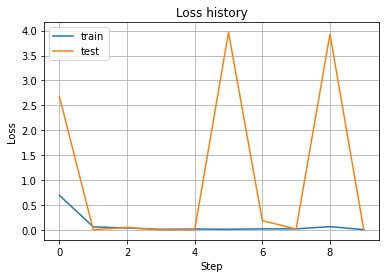

In [38]:
import matplotlib.pyplot as plt

plt.title('Loss history')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Step')
plt.plot(train_loss_history, label='train')
plt.plot(val_loss_history, label='test')
plt.legend()
plt.show()

In [39]:
# Проверим работу модели - Сделаем предсказание
input_test = torch.from_numpy(X_test).long()
test_outputs = net(input_test)
outputs_labels = np.where(test_outputs > 0.5, 1, 0)
test_outputs, outputs_labels

(tensor([[2.3550e-09],
         [3.3720e-03],
         [4.0982e-19],
         ...,
         [1.0983e-14],
         [3.5151e-24],
         [1.6699e-07]], grad_fn=<SigmoidBackward>),
 array([[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]]))

In [40]:
X_test.shape[0] == test_outputs.shape[0]

True

**Выводы:**  
Метрика в целом растет немонотонно.  
В качестве эксперимента увеличила количество слов в последовательности и количество эпох, а также уменьшила размер батча до 128, но это ожидаемо не оказало влияния на результат.  
В целом на средний уровень метрики положительно повлияла балансировка целевых значений в тренировочном датасете, однако подросло и переобучение